# Image Classification Model with Convolutional Neural Netwrok

## Background

This project proposes the development of an automated plant disease detection system using Convolutional Neural Networks (CNNs). Plant diseases are a major challenge to agricultural productivity and global food security, and traditional diagnosis methods often rely on expert knowledge, making them time-consuming, costly, and prone to error. By applying deep learning and computer vision techniques, the project aims to classify plant leaf images as healthy or diseased using image data.

The primary objective of the project is to design, train, and evaluate a CNN-based image classification model capable of accurately detecting plant diseases. The project workflow includes data collection and preprocessing, image augmentation, model development, and performance evaluation using standard metrics such as accuracy, precision, recall, F1-score, and confusion matrices. Additionally, the project compares a custom-built CNN with transfer learning models such as MobileNetV2 or ResNet50 to assess improvements in accuracy and efficiency.

The project is significant for farmers, agricultural extension workers, researchers, and students by providing a low-cost, accessible tool for early disease detection and decision support. Although the scope is limited to image-based classification using controlled datasets, the project contributes to the advancement of smart agriculture and demonstrates the practical application of deep learning in addressing real-world challenges related to sustainable farming and food security.


# Data source 
 A summary of the data has to be summarized here...

## Packages download

In [1]:
import pandas as pd
import numpy as np
import warnings
#import mlflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import sys, tensorflow as tf
print("Python:", sys.executable)
print("TensorFlow version:", getattr(tf, "__version__", "NO_VERSION"))
print("TensorFlow file:", getattr(tf, "__file__", "NO_FILE"))
print("Has tf.keras:", hasattr(tf, "keras"))


Python: c:\Users\ogina\Desktop\DS_Bootcamp\Capstone_Project\image_clasification_model\.venv\Scripts\python.exe
TensorFlow version: 2.15.0
TensorFlow file: c:\Users\ogina\Desktop\DS_Bootcamp\Capstone_Project\image_clasification_model\.venv\Lib\site-packages\tensorflow\__init__.py
Has tf.keras: True


## Data loading and EDA

In [5]:
from pathlib import Path
data_dir = Path(("../data/raw/PlantVillage"))
print(data_dir.exists(), data_dir.resolve())
classes = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])
print("Classes:", classes)
print("Number of classes:", len(classes))


True C:\Users\ogina\Desktop\DS_Bootcamp\Capstone_Project\image_clasification_model\data\raw\PlantVillage
Classes: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites_Two_spotted_spider_mite', 'Target_Spot', 'YellowLeaf__Curl_Virus', 'healthy', 'mosaic_virus']
Number of classes: 10


In [6]:
counts = []
for c in classes:
    n = len(list((data_dir / c).glob("*.jpg"))) + len(list((data_dir / c).glob("*.png"))) + len(list((data_dir / c).glob("*.jpeg")))
    counts.append((c, n))

df_counts = pd.DataFrame(counts, columns=["class", "num_images"]).sort_values("num_images", ascending=False)
df_counts

,class,num_images
8,healthy,3221
7,YellowLeaf__Curl_Virus,3208
0,Bacterial_spot,3124
2,Late_blight,2909
1,Early_blight,2000
4,Septoria_leaf_spot,1771
5,Spider_mites_Two_spotted_spider_mite,1676
6,Target_Spot,1404
3,Leaf_Mold,952
9,mosaic_virus,373


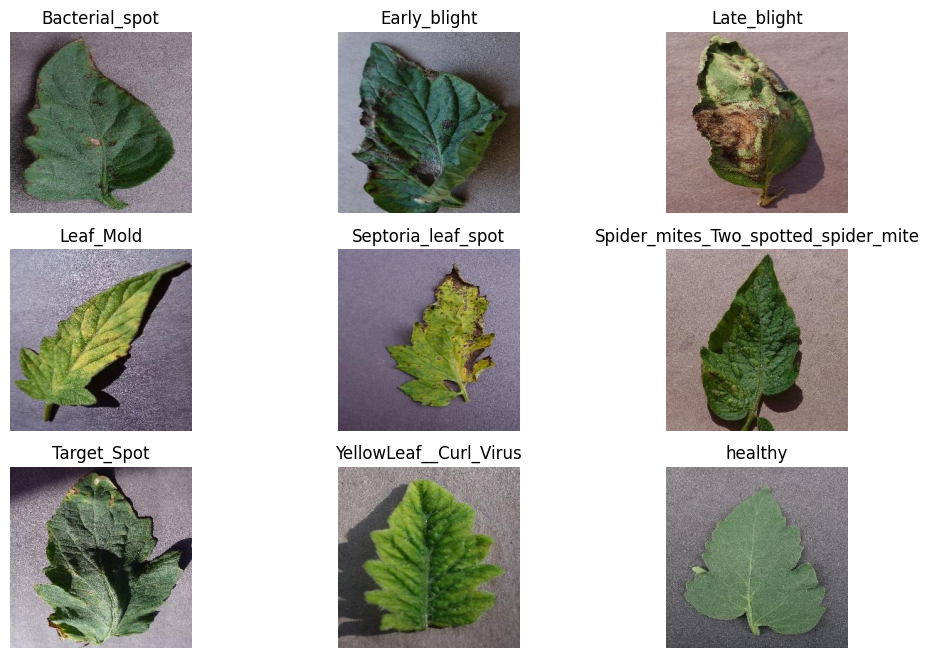

In [7]:
import random
import matplotlib.pyplot as plt
from PIL import Image

sample_paths = []
for c in classes:
    imgs = list((data_dir / c).glob("*.jpg")) + list((data_dir / c).glob("*.png")) + list((data_dir / c).glob("*.jpeg"))
    if imgs:
        sample_paths.append(random.choice(imgs))

plt.figure(figsize=(12, 8))
for i, p in enumerate(sample_paths[:9]):
    img = Image.open(p)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(p.parent.name)
    plt.axis("off")
plt.show()


## Train/validation/test split - do not change!

All splits are index-based and reproducible across machines using a fixed random seed. Test set will be put away for now to avoid data leakage.

In [8]:
# Prepare image paths and labels

# adjust the path if needed
# data_dir = Path("../data/raw/PlantVillage")

image_paths = []
labels = []

class_names = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

for cls in class_names:
    for img in (data_dir / cls).glob("*"):
        image_paths.append(img)
        labels.append(class_to_idx[cls])

image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Total images: {len(image_paths)}")


Total images: 20639


In [ ]:
# Dev/Test split. Important: test_paths is sacred! Don't touch it till the very end of the project.

from sklearn.model_selection import train_test_split

SEED = 42

dev_paths, test_paths, dev_labels, test_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.15,
    stratify=labels,
    random_state=SEED
)

print(f"Dev set: {len(dev_paths)}")
print(f"Test set: {len(test_paths)}")


Dev set: 17543
Test set: 3096


In [10]:
# Train/validation split for dev set

train_paths, val_paths, train_labels, val_labels = train_test_split(
    dev_paths,
    dev_labels,
    test_size=0.2,
    stratify=dev_labels,
    random_state=SEED
)

print(f"Train: {len(train_paths)}")
print(f"Validation: {len(val_paths)}")


Train: 14034
Validation: 3509


In [11]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

def make_dataset(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths.astype(str), labels))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_paths, train_labels, shuffle=True)
val_ds   = make_dataset(val_paths, val_labels)
test_ds  = make_dataset(test_paths, test_labels)
